In [1]:
from molmap import loadmap
from joblib import load, dump
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
import warnings, os
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm

from aggmap.show import imshow, imshow_wrap
from aggmap.utils.matrixopt import smartpadding

warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [90]:
from config import P
data_save_folder = P.mnist_data_save_folder
mnist_labels_dict = P.mnist_labels_dict

results_save_folder = P.results_save_folder
color_list = P.color_list
res_save_folder = './X-AI'

In [35]:
#agg
X_ORSAgg1 = load(os.path.join(data_save_folder, '03_X_ORSAgg1.data'))

#cluster split channel
X_ORSAggC5 = load(os.path.join(data_save_folder, '04_X_ORSAggC5.data'))


mp_ORSAgg1 = loadmap(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
mp_ORSAggC5 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC5.mp'))

model_OR1 = tf.keras.models.load_model(os.path.join(results_save_folder, 'model_Org1.h5')) 
model_OrgRP1 = tf.keras.models.load_model(os.path.join(results_save_folder, 'model_OrgRP1.h5'))
model_ORSAgg1 = tf.keras.models.load_model(os.path.join(results_save_folder, 'model_OrgRPAgg1.h5')) 
model_ORSAggC5 = tf.keras.models.load_model(os.path.join(results_save_folder, 'model_OrgRPAgg5.h5'))

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #(x_train, y_train), (x_test, y_test)
trainY = pd.get_dummies(y_train).values.astype(float)
testY = pd.get_dummies(y_test).values.astype(float)


In [5]:
from fmp import CalcFeatImp, CalcFeatImpEach

# 1. OVERALL-interpret ORSAgg-1

In [11]:
name = 'ORSAgg1'

model = model_ORSAgg1
mp = mp_ORSAgg1
trainX, testX = X_ORSAgg1


X = testX
Y = testY

arrX = X / 255.

dfY = pd.DataFrame(Y, columns = ['label_%s' % i for i in range(Y.shape[-1])])

dfimp_overall = CalcFeatImp(model, mp, arrX, dfY, task_type='classification', sigmoidy=False)


The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [ ]:
fig, axes = plt.subplots(nrows= 1, ncols= 10, figsize=(30, 4), sharex = False, sharey = False)

row = 'RPAgg1'
for ax, col in zip(axes, dfimp_overall.columns[-10:]):
    IMP = dfimp_overall[col].values.reshape(mp._S.fmap_shape)
    #fig, ax  = plt.subplots(1, 1, figsize=(7, 6))
    PCM = ax.imshow(np.log10(IMP), cmap = 'rainbow') #
    ax.set_xticks([]) 
    ax.set_yticks([])
    clb = plt.colorbar(PCM, ax = ax, shrink = 0.8, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    #clb.ax.set_title('log importance')

cols = ['label_%s' % i for i in range(Y.shape[-1])]
for ax, col in zip(axes, cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
    

axes[0].set_ylabel(row, fontsize = 30)  

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)

fig.savefig(os.path.join(res_save_folder, 'xAI_overall_%s.png' % name), bbox_inches='tight', dpi=400) 

# 2. OVERALL-interpret ORSAgg-5

In [7]:
name = 'ORSAgg5'

model = model_ORSAggC5
mp = mp_ORSAggC5
trainX, testX = X_ORSAggC5


X = testX
Y = testY

arrX = X / 255.

dfY = pd.DataFrame(Y, columns = ['label_%s' % i for i in range(Y.shape[-1])])

dfimp_overall2 = CalcFeatImp(model, mp, arrX, dfY, apply_logrithm = True, task_type='classification', sigmoidy=False)


In [ ]:
fig, axes = plt.subplots(nrows= 1, ncols= 10, figsize=(30, 4), sharex = False, sharey = False)
for ax, col in zip(axes, dfimp_overall2.columns[-10:]):
    IMP = dfimp_overall2[col].values.reshape(mp._S.fmap_shape)
    #fig, ax  = plt.subplots(1, 1, figsize=(7, 6))
    PCM = ax.imshow(np.log10(IMP), cmap = 'rainbow') #
    ax.set_xticks([]) 
    ax.set_yticks([])
    clb = plt.colorbar(PCM, ax = ax, shrink = 0.8, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    #clb.ax.set_title('log importance')

cols = ['label_%s' % i for i in range(Y.shape[-1])]
for ax, col in zip(axes, cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
    
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=None)

row = 'RPAgg5'
axes[0].set_ylabel(row, fontsize = 30) 
fig.savefig(os.path.join(res_save_folder, 'xAI_overall_%s.png' % name), bbox_inches='tight', dpi=400) 

# 3. Test Set: One Image-interpret ORSAgg-1

In [25]:
label_idxs = pd.Series(y_test).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())
image_idx = [pd.Series(label_idxs[i][:1]).sample(1, random_state = 1).to_list()[0] for i in range(len(label_idxs))]

image_idx

[3, 2, 1, 18, 4, 8, 11, 0, 61, 7]

In [26]:
names = list(mnist_labels_dict.values())
names = [i + '-%s' % j for i,j in zip(names, image_idx)]

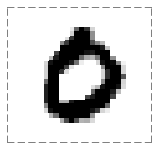

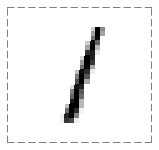

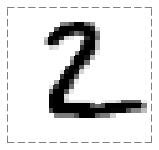

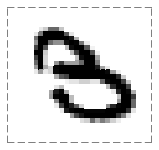

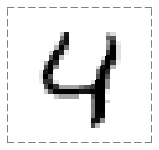

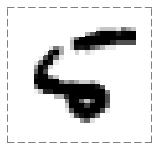

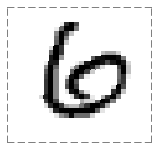

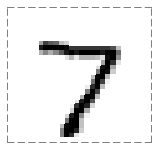

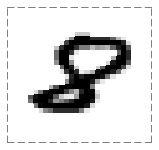

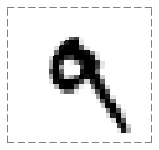

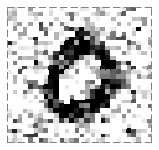

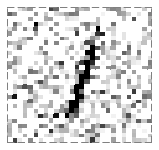

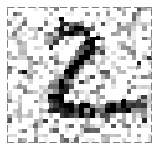

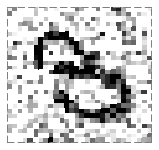

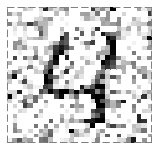

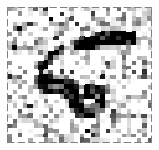

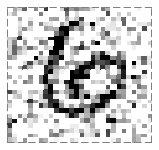

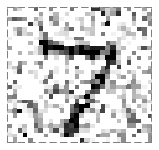

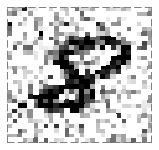

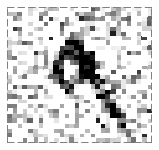

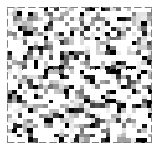

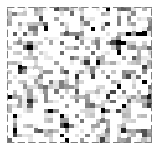

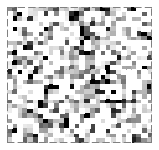

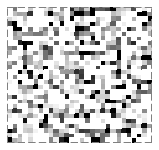

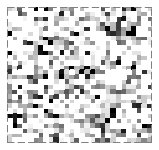

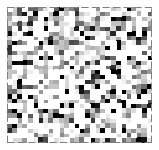

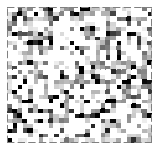

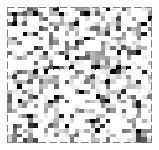

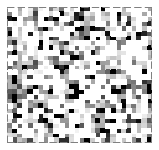

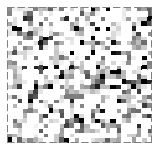

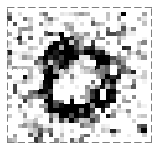

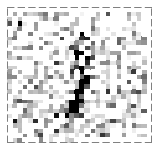

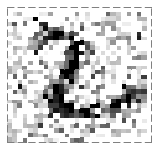

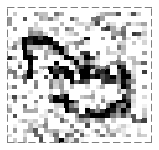

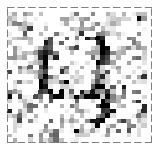

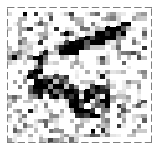

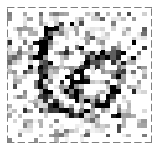

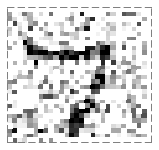

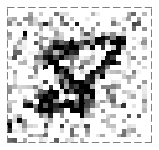

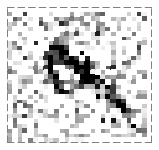

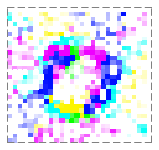

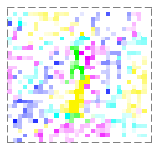

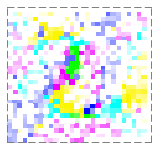

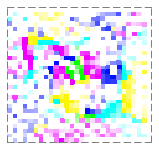

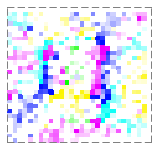

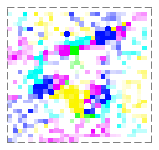

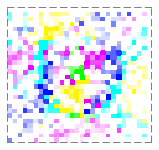

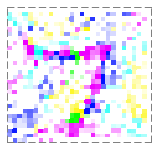

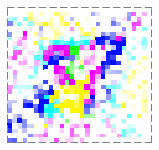

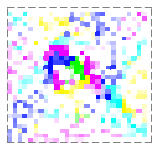

In [33]:
save_folder = './flowcharts/test-noise'

testX_org = load(os.path.join(data_save_folder, '01_X_OR1.data'))[1]
testX_noisys_org =  load(os.path.join(data_save_folder, 'testX_noisys.data'))[3] #stddev = 0.36
testX_noisys_shuffle_OrgRP1 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle.data'))[3]
testX_noisys_shuffle_ORSAgg1 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAgg1.data'))[3] 
testX_noisys_shuffle_ORSAggC5 =  load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC5.data'))[3] 

typs = ['Org1', 'Org1-N','OrgRP1', 'OrgRPAgg1', 'OrgRPAgg5']
datas = [testX_org, testX_noisys_org, testX_noisys_shuffle_OrgRP1, testX_noisys_shuffle_ORSAgg1, testX_noisys_shuffle_ORSAggC5]


for typ, data in zip(typs, datas):
    for name, idx in zip(names, image_idx):
        x = data[idx]*1.
        
        fdname = os.path.join(save_folder, typ)
        if not os.path.exists(fdname):
            os.makedirs(fdname)
        fname = os.path.join(fdname, '%s.png' % name)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.6, 2.5))
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'], vmin = 0,  mode = 'light')
        else:
            imshow(x, ax=ax, color_list = pd.Series(mp_ORSAggC5.colormaps).tolist(), vmin = 0 , mode = 'light')

        fig.savefig(fname, bbox_inches='tight', dpi=400) 

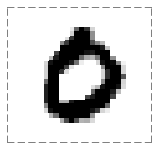

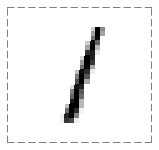

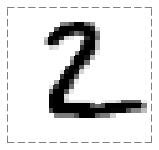

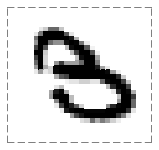

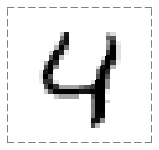

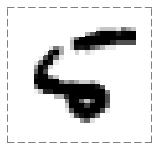

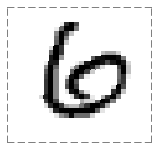

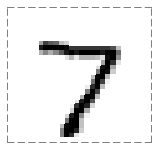

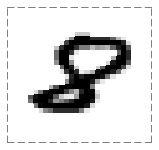

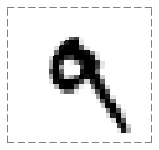

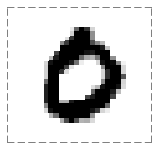

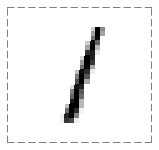

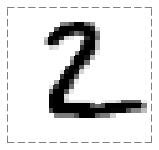

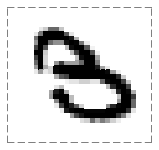

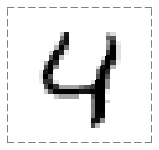

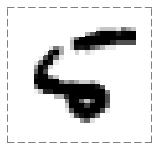

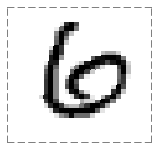

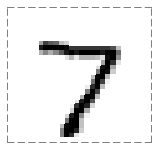

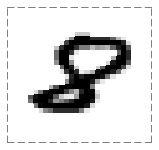

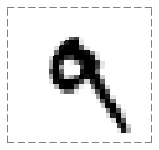

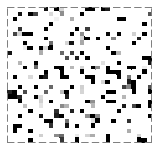

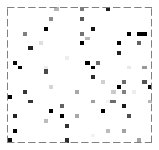

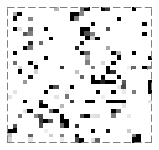

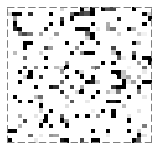

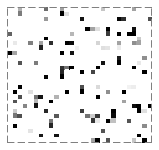

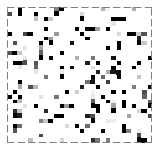

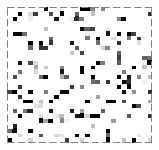

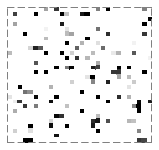

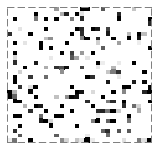

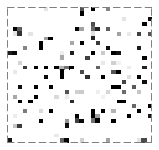

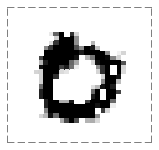

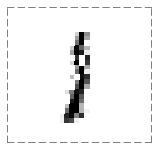

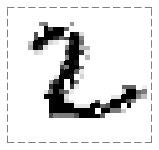

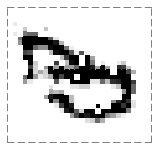

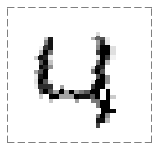

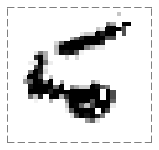

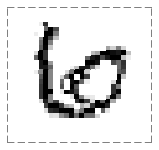

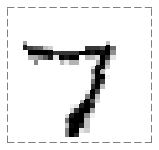

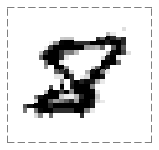

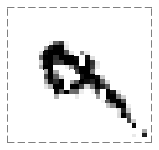

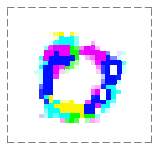

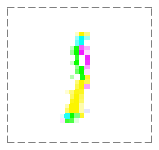

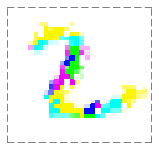

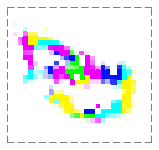

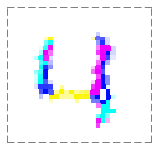

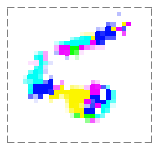

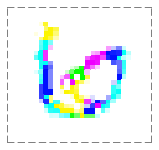

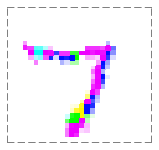

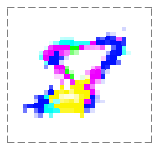

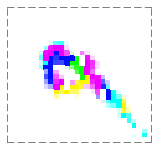

In [52]:
save_folder = './flowcharts/test-clean'

testX_org = load(os.path.join(data_save_folder, '01_X_OR1.data'))[1]
testX_clean_org =  load(os.path.join(data_save_folder, 'testX_noisys.data'))[0] #stddev = 0.0
testX_clean_shuffle_OrgRP1 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle.data'))[0]
testX_clean_shuffle_ORSAgg1 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAgg1.data'))[0] 
testX_clean_shuffle_ORSAggC5 =  load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC5.data'))[0] 

typs = ['Org1', 'Org1-clean', 'OrgRP1', 'OrgRPAgg1', 'OrgRPAgg5']
datas = [testX_org, testX_clean_org, testX_clean_shuffle_OrgRP1, testX_clean_shuffle_ORSAgg1, testX_clean_shuffle_ORSAggC5]


for typ, data in zip(typs, datas):
    for name, idx in zip(names, image_idx):
        x = data[idx]*1.
        
        fdname = os.path.join(save_folder, typ)
        if not os.path.exists(fdname):
            os.makedirs(fdname)
        fname = os.path.join(fdname, '%s.png' % name)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.6, 2.5))
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'], vmin = 0,  mode = 'light')
        else:
            imshow(x, ax=ax, color_list = pd.Series(mp_ORSAggC5.colormaps).tolist(), vmin = 0 , mode = 'light')

        fig.savefig(fname, bbox_inches='tight', dpi=400) 

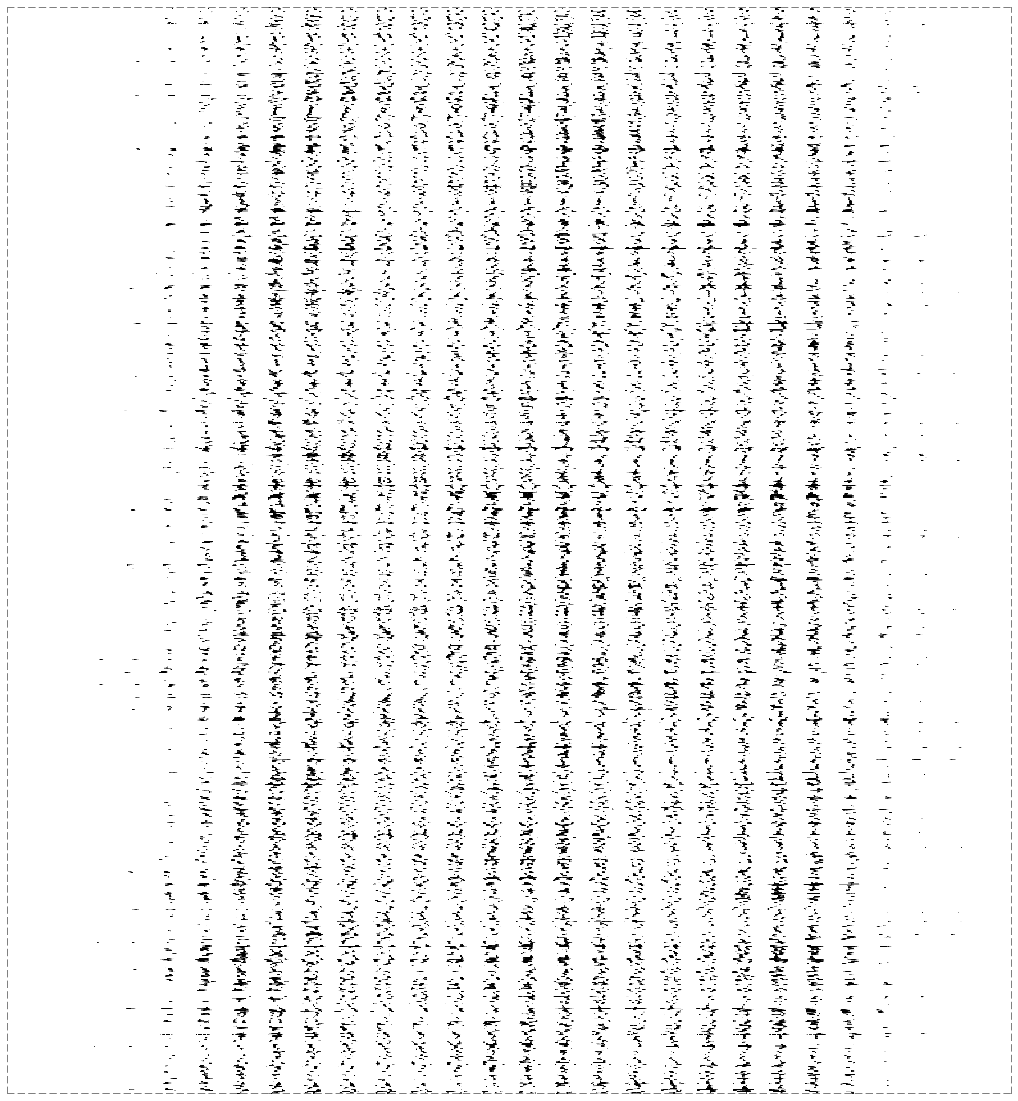

In [53]:
X = testX_org.copy()
n = 1000
x = (X[:n]).reshape((n, 784, 1))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 20))
imshow(x*1., ax=ax, color_list = ['black'], vmin = 0,  mode = 'light')
fig.savefig(os.path.join(res_save_folder, './test_reshape.png'), bbox_inches='tight', dpi=400) 


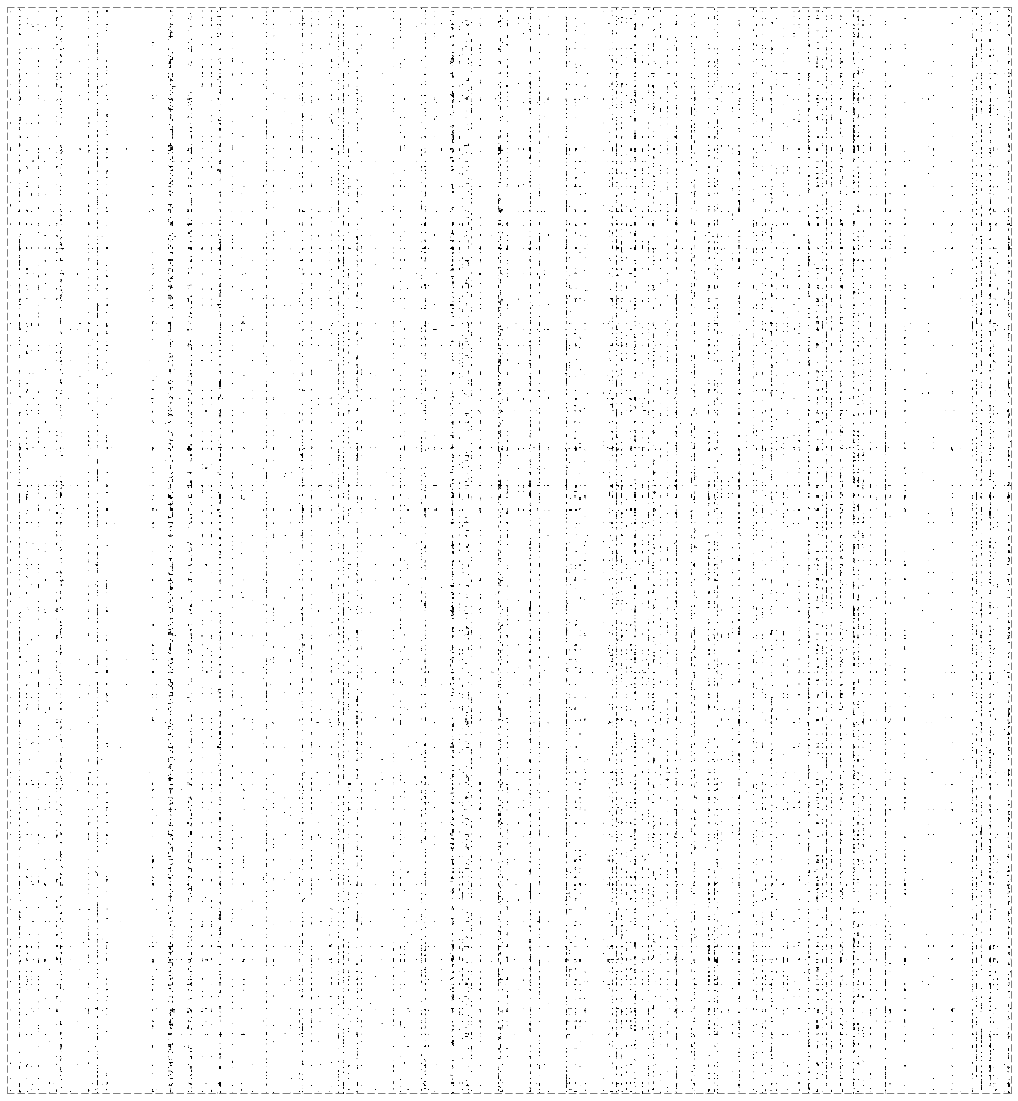

In [54]:
X = testX_clean_shuffle_OrgRP1.copy()
n = 1000
x = (X[:n]).reshape((n, 784, 1))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 20))
imshow(x*1., ax=ax, color_list = ['black'], vmin = 0,  mode = 'light')
fig.savefig(os.path.join(res_save_folder, './test_shuffle_reshape.png'), bbox_inches='tight', dpi=400) 


2021-03-12 19:14:34,816 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:14:34,859 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [01:14<00:00,  9.77it/s]


2021-03-12 19:15:50,548 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:15:50,596 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.69it/s]


2021-03-12 19:16:41,177 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:16:41,202 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.70it/s]


2021-03-12 19:17:31,929 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:17:31,964 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:50<00:00, 14.52it/s]


2021-03-12 19:18:23,135 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:18:23,155 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.85it/s]


2021-03-12 19:19:13,175 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:19:13,217 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:48<00:00, 14.98it/s]


2021-03-12 19:20:02,798 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:20:02,835 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.83it/s]


2021-03-12 19:20:52,887 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:20:52,927 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.71it/s]


2021-03-12 19:21:43,140 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:21:43,174 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.67it/s]


2021-03-12 19:22:33,586 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:22:33,641 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.60it/s]


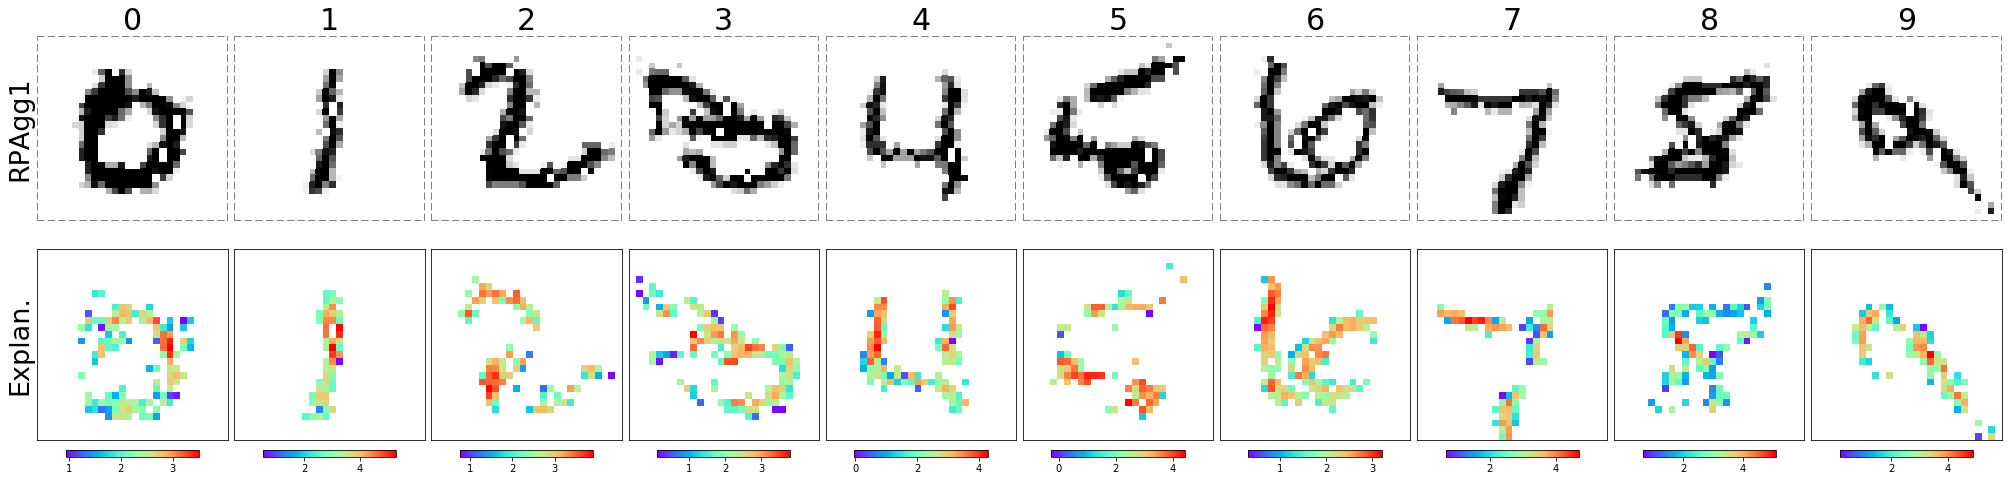

In [87]:
label_idxs = pd.Series(y_test).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())
image_idx = [pd.Series(label_idxs[i][:1]).sample(1, random_state = 1).to_list()[0] for i in range(len(label_idxs))]

name = 'RPAgg1'
fontsize = 27

model = model_ORSAgg1
mp = mp_ORSAgg1
trainX, testX = X_ORSAgg1

fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), sharex = False, 
                         sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})


rows = ['RPAgg1', 'Explan.']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 

for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = ['black'], x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = True)
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    IMP = smartpadding(IMPM, arrX[0].shape[:-1], constant_values = IMPM.min())
    IMP[IMP == IMP.min()] = np.nan
    PCM = ax2.imshow(IMP, cmap = 'rainbow')
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    #clb.ax.set_title('FI', loc = 'left', pad = 0.25)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(res_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 

# 4. Test Set: OneImage-interpret ORSAgg-C5

2021-03-12 19:24:09,342 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:24:09,383 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:50<00:00, 14.42it/s]


2021-03-12 19:25:02,979 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:25:03,030 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:50<00:00, 14.55it/s]


2021-03-12 19:25:56,006 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:25:56,045 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:50<00:00, 14.53it/s]


2021-03-12 19:26:48,798 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:26:48,836 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.68it/s]


2021-03-12 19:27:41,500 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:27:41,545 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.78it/s]


2021-03-12 19:28:33,162 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:28:33,196 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.65it/s]


2021-03-12 19:29:25,400 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:29:25,439 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:50<00:00, 14.45it/s]


2021-03-12 19:30:17,849 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:30:17,883 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:50<00:00, 14.53it/s]


2021-03-12 19:31:10,266 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:31:10,306 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:48<00:00, 14.93it/s]


2021-03-12 19:32:00,907 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 19:32:00,949 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:49<00:00, 14.81it/s]


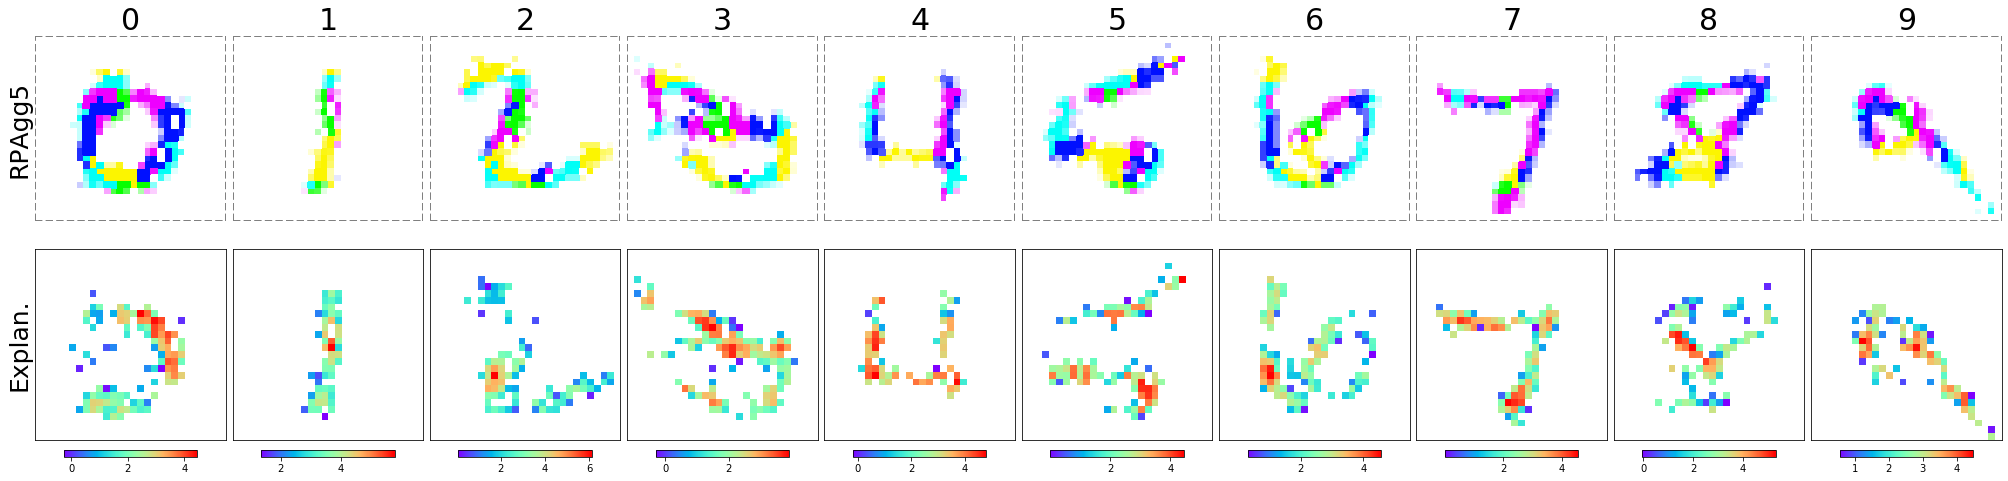

In [88]:
name = 'RPAgg5'

model = model_ORSAggC5
mp = mp_ORSAggC5
trainX, testX = X_ORSAggC5
    
fontsize = 25

fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), 
                         sharex = False, sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})


rows = ['RPAgg5', 'Explan.']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 


for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = pd.Series(mp.colormaps).tolist(), x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = True)
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    IMP = smartpadding(IMPM, arrX[0].shape[:-1], constant_values = IMPM.min())
    IMP[IMP == IMP.min()] = np.nan
    PCM = ax2.imshow(IMP, cmap = 'rainbow')
    
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    
    #clb = plt.colorbar(PCM, ax = ax2, shrink = 0.5, pad = -1.3,  format = '%.0f', orientation = 'horizontal') #orientation = 'horizontal',
    #clb.ax.set_title('log importance')  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(res_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 

# 5. Test Set: OneImage-interpret ORSAgg1, Gauss noisy 0.36

2021-03-12 21:28:43,674 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:28:43,701 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:52<00:00, 13.84it/s]


2021-03-12 21:29:37,544 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:29:37,572 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [01:30<00:00,  8.05it/s]


2021-03-12 21:31:09,451 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:31:09,494 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:52<00:00, 13.78it/s]


2021-03-12 21:32:03,640 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:32:03,673 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:52<00:00, 13.80it/s]


2021-03-12 21:32:57,610 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:32:57,653 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:52<00:00, 13.88it/s]


2021-03-12 21:33:51,036 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:33:51,060 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:51<00:00, 14.03it/s]


2021-03-12 21:34:43,817 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:34:43,845 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.63it/s]


2021-03-12 21:35:38,129 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:35:38,157 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:52<00:00, 13.79it/s]


2021-03-12 21:36:31,671 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:36:31,693 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.64it/s]


2021-03-12 21:37:25,781 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:37:25,812 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.73it/s]


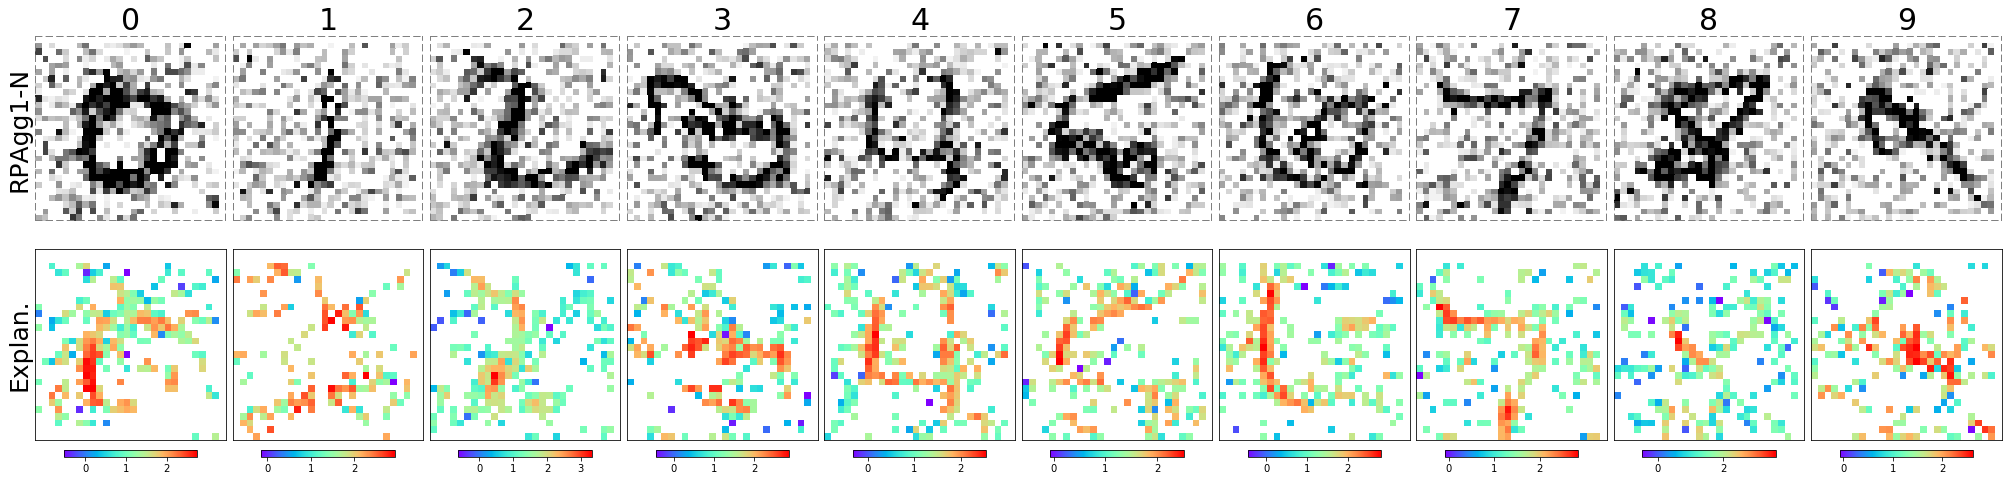

In [91]:
testX_noisys_shuffle_ORSAgg1 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAgg1.data')) 
testX = testX_noisys_shuffle_ORSAgg1[3] #stddev = 0.36
name = 'RPAgg1-Gauss-0.36'

model = model_ORSAgg1
mp = mp_ORSAgg1
fontsize = 25

fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), sharex = False, sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})

rows = ['RPAgg1-N', 'Explan.']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 


for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = ['black'], x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = True)
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    IMP = smartpadding(IMPM, arrX[0].shape[:-1], constant_values = IMPM.min())
    IMP[IMP == IMP.min()] = np.nan
    PCM = ax2.imshow(IMP, cmap = 'rainbow')
    
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    
    #clb = plt.colorbar(PCM, ax = ax2, shrink = 0.5, pad = -1.3,  format = '%.0f', orientation = 'horizontal') #orientation = 'horizontal',
    #clb.ax.set_title('log importance')  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(res_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 

# 6. Test Set: OneImage-interpret ORSAgg5, Gauss noisy 0.36

2021-03-12 21:38:39,233 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:38:39,275 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.73it/s]


2021-03-12 21:39:35,812 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:39:35,855 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.68it/s]


2021-03-12 21:40:32,156 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:40:32,193 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.75it/s]


2021-03-12 21:41:27,876 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:41:27,910 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.70it/s]


2021-03-12 21:42:23,630 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:42:23,678 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:52<00:00, 13.80it/s]


2021-03-12 21:43:19,341 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:43:19,373 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.74it/s]


2021-03-12 21:44:14,914 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:44:14,945 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [01:41<00:00,  7.16it/s] 


2021-03-12 21:45:58,964 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:45:59,013 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.52it/s]


2021-03-12 21:46:54,872 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:46:54,917 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.68it/s]


2021-03-12 21:47:50,033 - INFO - [bidd-aggmap] - generate file: ./feature points_717_correlation_umap_mp
2021-03-12 21:47:50,071 - INFO - [bidd-aggmap] - save html file to ./feature points_717_correlation_umap_mp


100%|##########| 729/729 [00:53<00:00, 13.67it/s]


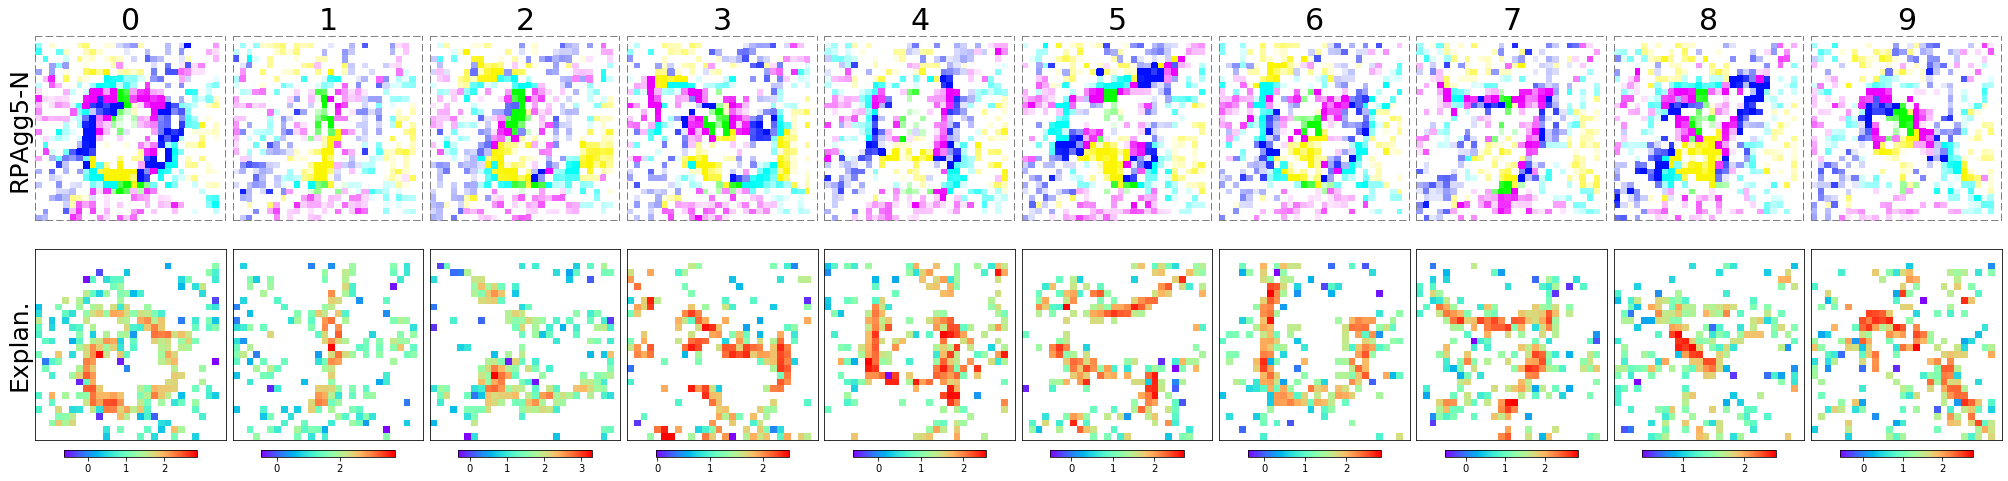

In [92]:
testX_noisys_shuffle_ORSAggC5 = load(os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC5.data')) 
testX = testX_noisys_shuffle_ORSAggC5[3] #stddev = 0.36
name = 'RPAgg5-Gauss-0.36'

model = model_ORSAggC5
mp = mp_ORSAggC5
fontsize = 25



fig, axes = plt.subplots(nrows= 2, ncols= 10, figsize=(28, 7), sharex = False, sharey = False, gridspec_kw={'height_ratios': [1, 1.4]})
rows = ['RPAgg5-N', 'Explan.']
cols = list(mnist_labels_dict.values())
cols = [i for i,j in zip(cols, image_idx)] #+ '-%s' % j 


for axs, idx in zip(axes.T, image_idx):
    
    ax1, ax2 = axs    
    i = idx
    X = testX
    Y = testY
    arrX = X[[i]] / 255.

    dfy = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = dfy.iloc[[i]]

    imshow(arrX[0], ax = ax1, mode='light', color_list = pd.Series(mp.colormaps).tolist(), x_max = 1, vmin = 0)

    dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = True)
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    IMP = smartpadding(IMPM, arrX[0].shape[:-1], constant_values = IMPM.min())
    IMP[IMP == IMP.min()] = np.nan
    PCM = ax2.imshow(IMP, cmap = 'rainbow')
    ax2.set_xticks([]) 
    ax2.set_yticks([])
    
    clb = plt.colorbar(PCM, ax = ax2, shrink = 0.7, pad = 0.04,  orientation = 'horizontal') #format = '%.2f'
    
    #clb = plt.colorbar(PCM, ax = ax2, shrink = 0.5, pad = -1.3,  format = '%.0f', orientation = 'horizontal') #orientation = 'horizontal',
    #clb.ax.set_title('log importance')  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': 30})
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)  

#plt.title('Model training on %s' % name, fontdict={'fontsize':fontsize})    

fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.035, hspace=0.035)
fig.savefig(os.path.join(res_save_folder, 'xAI_OneTestimage_%s.png' % name), bbox_inches='tight', dpi=400) 